# LAB: Stochastic Gradient Descent SOLUTIONS

The objective of this lab session is to implement:
- Stochastic gradient descent with constant stepsizes
- Stochastic gradient descent with shrinking stepsizes
- Stochastic gradient descent with sampling with/without replacement
- Stochastic gradient descent with averaging 
- Stochastic gradient descent with momentum 

and compare your implementation with gradient descent.

Throughout the notebook you will find commented boxes like this one:

In [1]:
### TODO ###   
# please implement blabla
#############

These boxes need to be replaced by code as explained in the boxes.
Solutions will online tomorrow. Good luck!

In [2]:
%matplotlib inline

In [3]:
import numpy as np
from numpy import linalg as la
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit, jit, jitclass  # A just in time compiler to speed things up!

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes

We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(x_i^\top w, b_i) + \frac \lambda 2 \|w\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(w)
$$
where
$$
f_i(w) = \ell(x_i^\top w, y_i) + \frac \lambda 2 \|w\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(w) = (x_i^\top w - y_i) x_i + \lambda w
$$
and
$$
\nabla f_i(w) = - \frac{y_i}{1 + \exp(y_i x_i^\top w)} x_i + \lambda w.
$$

Denote by $L$ the Lipschitz constant of $f$ and $X = [x_1, \ldots, x_n].$
One can see easily that for linear regression
$$
L = \frac{ \|\mathbf X \mathbf X^\top \|_{2}}{n} + \lambda 
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf X \mathbf X^\top \|_{2}}{4 n} + \lambda 
$$
For full-gradient methods, the theoretical step-size is $1 / L$.

We now introduce a class that will be used for the solvers.

In [4]:
from scipy.linalg import svd

class LinReg(object):
    """A class for the least-squares regression with
    Ridge penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda  
# (1/n)X (X^Tw-y) + lbda*w        
    def grad(self, w):
        return self.X.T.dot(self.X.dot(w) - self.y) / self.n + self.lbda * w
    
    def f_i(self, i, w):
        return norm(self.X[i].dot(w) - self.y[i]) ** 2 / (2.) + self.lbda * norm(w) ** 2 / 2.  
    
    def f(self, w):
        return norm(self.X.dot(w) - self.y) ** 2 / (2. * self.n) + self.lbda * norm(w) ** 2 / 2.
# (1/n)X_i (X_i^Tw-y_i) + lbda*w    
    def grad_i(self, i, w):
        x_i = self.X[i]
        return (x_i.dot(w) - self.y[i]) * x_i + self.lbda * w

    def lipschitz_constant(self):
        """Return the smoothness constant (Lipschitz constant of the gradient)"""
        L = norm(self.X, ord=2) ** 2 / self.n + self.lbda
        return L
    
    def L_max_constant(self):
        """Return the L_max constant """
        L_max = np.max(np.sum(self.X ** 2, axis=1)) + self.lbda
        return L_max 
    
    def mu_constant(self):
        """Return the strong convexity constant"""
        mu =  min(abs(la.eigvals(np.dot(self.X.T,self.X)))) / self.n + self.lbda
        return mu     

In [5]:
class LogReg(object):
    """A class for the logistic regression with L2 penalization"""

    def __init__(self, X, y, lbda):
        self.X = X
        self.y = y
        self.n, self.d = X.shape
        self.lbda = lbda
 
    def grad(self, w):
        bAx = self.y * self.X.dot(w)
        temp = 1. / (1. + np.exp(bAx))
        grad = - (self.X.T).dot(self.y * temp) / self.n + self.lbda * w
        return grad
    
    def f_i(self,i, w):
        bAx_i = self.y[i] * np.dot(self.X[i], w)
        return np.log(1. + np.exp(- bAx_i)) + self.lbda * norm(w) ** 2 / 2.
    
    def f(self, w):
#         bAx = (self.X.dot(w)).dot(self.y)
        bAx = self.y * self.X.dot(w)
        return np.mean(np.log(1. + np.exp(- bAx))) + self.lbda * norm(w) ** 2 / 2.
# (1/n)X (X^Tw-y) + lbda*w    
    def grad_i(self, i, w):
        grad = - self.X[i] * self.y[i] / (1. + np.exp(self.y[i] 
                                                      * self.X[i].dot(w)))
        grad += self.lbda * w
        return grad
    # \nabla f_i(w) = - \frac{y_i}{1 + \exp(y_i x_i^\top w)} x_i + \lambda w.

    def lipschitz_constant(self):
        """Return the smoothness constant (Lipschitz constant of the gradient)"""
        L = norm(self.X, ord=2) ** 2  / (4. * self.n) + self.lbda
        return L
    def L_max_constant(self):
        """Return the L_max constant """
        L_max = np.max(np.sum(self.X ** 2, axis=1))/4 + self.lbda
        return L_max 
    
    def mu_constant(self):
        """Return the strong convexity constant"""
        mu =  self.lbda
        return mu    

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [6]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz

    
def simu_linreg(w, n, std=1., corr=0.5):
    """
    Simulation of the least-squares problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

In [7]:
def simu_logreg(w, n, std=1., corr=0.5):
    """
    Simulation of the logistic regression problem
    
    Parameters
    ----------
    x : np.ndarray, shape=(d,)
        The coefficients of the model
    
    n : int
        Sample size
    
    std : float, default=1.
        Standard-deviation of the noise

    corr : float, default=0.5
        Correlation of the features matrix
    """    
    X, y = simu_linreg(w, n, std=1., corr=0.5)
    return X, np.sign(y)

### Generate Data

In [8]:
d = 50
n = 1000
idx = np.arange(d)

# Ground truth coefficients of the model
w_model_truth = (-1)**idx * np.exp(-idx / 10.)

#X, y = simu_linreg(w_model_truth, n, std=1., corr=0.1)
X, y = simu_logreg(w_model_truth, n, std=1., corr=0.7)

In [9]:
### Choice of the model

In [10]:
lbda = 1. / n ** (0.5)
#model = LinReg(X, y, lbda)
model = LogReg(X, y, lbda)


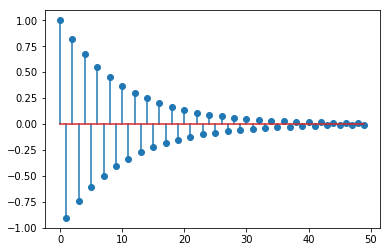

In [11]:
plt.stem(w_model_truth); 

In [12]:
from scipy.optimize import check_grad
modellog = LogReg(X, y, lbda)
# Check that the gradient and the loss numerically match
check_grad(modellog.f, modellog.grad, np.random.randn(d))

2.826696155810194e-07

In [13]:
modellin = LinReg(X, y, lbda)
# Check that the gradient and the loss numerically match
check_grad(modellin.f, modellin.grad, np.random.randn(d))

1.5066915066478644e-06

2.126802178681579e-07


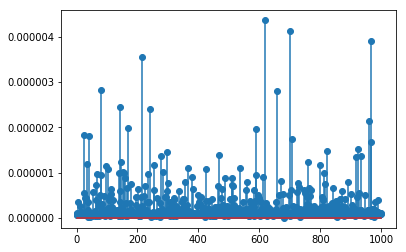

In [14]:
# Check that the gradient grad_i and the numerical gradient of f_i agree
grad_error = []
for i in range(n):
    ind = np.random.choice(n,1)
    w =  np.random.randn(d)
    vec =  np.random.randn(d)
    eps = pow(10.0, -7.0)
    model.f_i(ind[0],w)
    grad_error.append((model.f_i( ind[0], w+eps*vec) - model.f_i( ind[0], w))/eps - np.dot(model.grad_i(ind[0],w),vec))
plt.stem(grad_error); 
print(np.mean(grad_error))

### Find a highly accurate solution using LBFGS method

In [15]:
from scipy.optimize import fmin_l_bfgs_b

w_init = np.zeros(d)
w_min, obj_min, _ = fmin_l_bfgs_b(model.f, w_init, model.grad, args=(), pgtol=1e-30, factr =1e-30)

print(obj_min)
print(norm(model.grad(w_min)))

0.5007807733009136
1.6760635344948983e-09


<a id='constant'></a> 

## 3. Implementing Stochastic Gradient Descent


### SGD

We recall that an iteration of SGD writes



**for** $t = 1, \ldots, T$ 
  
$\qquad$ Pick $i$ uniformly at random in $\{1, \ldots, n\}$
   
$\qquad \displaystyle
w^{t+1} \gets w^t - \gamma^t \nabla f_i(w^t)
$
  
**end for**



Complete the code below. The inputs are
- n_iter: The number of iterations
- indices: an np.array of indices of length n_iter. The indices[k]  is the index of stochastic gradient that will be used on the kth iteration. 
- steps: an np.array of positive floats of length n_iter. The steps[k] is the stepsize used on the kth iteration. Typically decreasing stepsizes are used $\gamma^t = \frac{C}{t+1}$, where $C$ is tuned by hand.

- averaging_on: is a boolean which indicates if the output should be the average of the iterates.

The outputs are:
- x_output: The final x vector found by the algorithm or the average  $ \bar{w} = \frac{1}{T-t}\sum_{i=t}^T w^t$ if averaging is on
- objectives: A ndarray containing the sequence function values calculated during the iterations of the algorithm 
- errors: If w_min is not empty, errors is a ndarray containing the sequence of errors || x - w_min || of the algorithm. Otherwise errors should be empty.
*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [16]:
def sgd(w0, model, indices, steps, w_min, n_iter=100, averaging_on=False, momentum =0, verbose=True, start_late_averaging = 0):
    """Stochastic gradient descent algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = X.shape
    # average x
    w_average = w0.copy()
    w_test = w0.copy()
    w_old = w0.copy()
    # estimation error history
    errors = []
    err = 1.0
    # objective history
    objectives = []
    # Current estimation error
    if np.any(w_min):
        err = norm(w - w_min) / norm(w_min)
        errors.append(err)
    # Current objective
    obj = model.f(w) 
    objectives.append(obj)
    if verbose:
        print("Lauching SGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter):
        w_new[:] = w - steps[k] * (model.grad_i(indices[k],w) + momentum*(w - w_old))
        w_old[:] = w
        w[:] = w_new
        if k < start_late_averaging:
            w_average[:] = w
        else:    
            k_new = k-start_late_averaging
            w_average[:] = k_new / (k_new+1) * w_average + w / (k_new+1) # Calculating the average in the fly
            
        if averaging_on:
            w_test[:] = w_average
        else:
            w_test[:] = w
        obj = model.f(w_test) 
        if np.any(w_min):
            err = norm(w_test - w_min) / norm(w_min)
            errors.append(err)
        objectives.append(obj)
        if k % n_samples == 0 and verbose:
            if(sum(w_min)):
                print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
            else:
                print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8)]))
    if averaging_on:
        w_output = w_average.copy()
    else:
        w_output = w.copy()    
    return w_output, np.array(objectives), np.array(errors)

In [17]:
##Setup number of iterations
datapasses = 30  # number of sweeps through all the data. This means that there will datapasses*n stochastic gradient updates
n_iter = int(datapasses * n)

### SGD with constant step with replacement

In [18]:
Lmax = model.L_max_constant();

In [19]:
indices = np.random.choice(n, n_iter + 1, replace=True)
steps =  np.ones(n_iter + 1)/(2*Lmax)
np.size(indices)
w0 = np.zeros(d)
#  averaging_on=False, momentum =0, verbose=True, start_late_averaging = 0
w_sgdcr, obj_sgdcr, err_sgdcr = sgd(w0,model, indices, steps, w_min,n_iter)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 6.90e-01 | 9.96e-01
    1000 | 5.50e-01 | 3.47e-01
    2000 | 5.50e-01 | 3.11e-01
    3000 | 5.31e-01 | 2.75e-01
    4000 | 5.45e-01 | 3.01e-01
    5000 | 5.17e-01 | 2.23e-01
    6000 | 5.19e-01 | 2.05e-01
    7000 | 5.46e-01 | 2.81e-01
    8000 | 5.42e-01 | 3.00e-01
    9000 | 5.39e-01 | 3.00e-01
   10000 | 5.23e-01 | 2.33e-01
   11000 | 5.34e-01 | 2.76e-01
   12000 | 5.25e-01 | 2.45e-01
   13000 | 5.35e-01 | 2.94e-01
   14000 | 5.28e-01 | 2.72e-01
   15000 | 5.34e-01 | 2.74e-01
   16000 | 5.23e-01 | 2.40e-01
   17000 | 5.23e-01 | 2.27e-01
   18000 | 5.21e-01 | 2.41e-01
   19000 | 5.33e-01 | 2.44e-01
   20000 | 5.24e-01 | 2.54e-01
   21000 | 5.52e-01 | 3.09e-01
   22000 | 5.34e-01 | 2.64e-01
   23000 | 5.27e-01 | 2.64e-01
   24000 | 5.24e-01 | 2.32e-01
   25000 | 5.31e-01 | 3.00e-01
   26000 | 5.31e-01 | 2.66e-01
   27000 | 5.34e-01 | 2.66e-01
   28000 | 5.24e-01 | 2.44e-01
   29000 | 5.25e-01 | 2.73e-01


### SGD with $C/\sqrt{t+1}$ stepsizes with replacement

In [20]:
indices = np.random.choice(n, n_iter+1, replace = True)
steps =  2/(Lmax*(np.sqrt(np.arange(1, n_iter + 2))))
np.size(indices)
w_sgdsr, obj_sgdsr, err_sgdsr = sgd(w0,model, indices, steps, w_min, n_iter)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 6.93e-01 | 9.99e-01
    1000 | 5.78e-01 | 6.61e-01
    2000 | 5.54e-01 | 5.62e-01
    3000 | 5.42e-01 | 4.96e-01
    4000 | 5.33e-01 | 4.46e-01
    5000 | 5.28e-01 | 4.11e-01
    6000 | 5.25e-01 | 3.82e-01
    7000 | 5.21e-01 | 3.56e-01
    8000 | 5.19e-01 | 3.35e-01
    9000 | 5.17e-01 | 3.17e-01
   10000 | 5.15e-01 | 2.99e-01
   11000 | 5.14e-01 | 2.84e-01
   12000 | 5.12e-01 | 2.69e-01
   13000 | 5.12e-01 | 2.58e-01
   14000 | 5.10e-01 | 2.44e-01
   15000 | 5.09e-01 | 2.33e-01
   16000 | 5.09e-01 | 2.25e-01
   17000 | 5.08e-01 | 2.17e-01
   18000 | 5.08e-01 | 2.07e-01
   19000 | 5.07e-01 | 2.00e-01
   20000 | 5.07e-01 | 1.92e-01
   21000 | 5.06e-01 | 1.83e-01
   22000 | 5.06e-01 | 1.76e-01
   23000 | 5.05e-01 | 1.70e-01
   24000 | 5.05e-01 | 1.65e-01
   25000 | 5.05e-01 | 1.61e-01
   26000 | 5.05e-01 | 1.58e-01
   27000 | 5.05e-01 | 1.55e-01
   28000 | 5.04e-01 | 1.51e-01
   29000 | 5.04e-01 | 1.45e-01


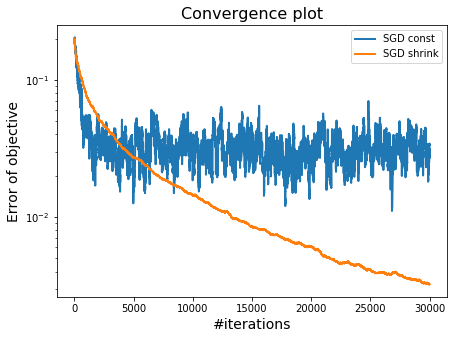

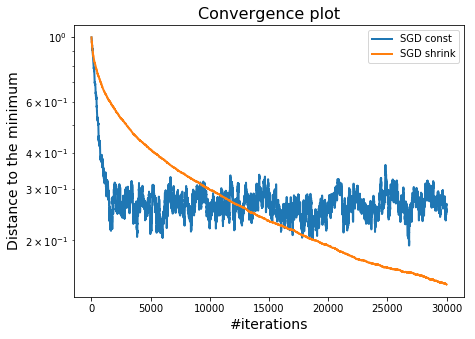

In [21]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD const", lw=2)
plt.semilogy(obj_sgdsr - obj_min, label="SGD shrink", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Error of objective", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdcr , label="SGD const", lw=2)
plt.semilogy(err_sgdsr , label="SGD shrink", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

**Questions**

- Compare the solution you obtain for SGD with constant stepsizes and SGD with shrinking stepsizes. 
- Which one is faster in the beginning? Which reaches the "best" solution?
- What happens when is you use sampling without replacement instead? Hint: Do only one datapass, it's annoying to adapt this implementation for more than one datapass when sampling without replacement



### SGD with switch to  shrinking stepsizes

In [22]:
mu = model.mu_constant();
Kappa = Lmax/mu;
tstar = 4*int(np.ceil(Kappa));

Test SGD with the following switching stepsizes given in the lecture

$\gamma^t= 
\begin{cases}
\displaystyle \tfrac{1}{2L_{\max}} & \mbox{for}\quad t \leq 4\lceil\mathcal{K} \rceil \\[0.3cm]
\displaystyle \tfrac{2t+1}{(t+1)^2 \mu} &  \mbox{for}\quad t > 4\lceil\mathcal{K} \rceil.
\end{cases}$

In [23]:
# np.ones(tstar).join(np.arange(1, niters + 2))
steps_switch = np.zeros(n_iter + 1)
for i in range(n_iter):
        if(i <= tstar):
            steps_switch[i] = 1/(2*Lmax);
        else:
            steps_switch[i] = (2*i+1)/((i+1)**2 *mu);

In [24]:
indices = np.random.choice(n, n_iter+1, replace = True)
np.size(indices)
w_sgdss, obj_sgdss, err_sgdss = sgd(w0,model, indices, steps_switch, w_min, n_iter)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 6.94e-01 | 9.99e-01
    1000 | 5.35e-01 | 3.21e-01
    2000 | 5.29e-01 | 2.29e-01
    3000 | 5.35e-01 | 2.75e-01
    4000 | 5.45e-01 | 2.93e-01
    5000 | 5.20e-01 | 2.09e-01
    6000 | 5.16e-01 | 1.95e-01
    7000 | 5.20e-01 | 2.13e-01
    8000 | 5.11e-01 | 1.85e-01
    9000 | 5.13e-01 | 1.69e-01
   10000 | 5.15e-01 | 1.68e-01
   11000 | 5.12e-01 | 1.59e-01
   12000 | 5.10e-01 | 1.48e-01
   13000 | 5.08e-01 | 1.42e-01
   14000 | 5.07e-01 | 1.17e-01
   15000 | 5.07e-01 | 1.26e-01
   16000 | 5.05e-01 | 1.12e-01
   17000 | 5.08e-01 | 1.28e-01
   18000 | 5.07e-01 | 1.23e-01
   19000 | 5.07e-01 | 1.30e-01
   20000 | 5.06e-01 | 1.07e-01
   21000 | 5.05e-01 | 9.99e-02
   22000 | 5.04e-01 | 9.79e-02
   23000 | 5.04e-01 | 9.49e-02
   24000 | 5.04e-01 | 9.87e-02
   25000 | 5.04e-01 | 8.28e-02
   26000 | 5.05e-01 | 9.17e-02
   27000 | 5.05e-01 | 9.68e-02
   28000 | 5.05e-01 | 9.61e-02
   29000 | 5.04e-01 | 9.09e-02


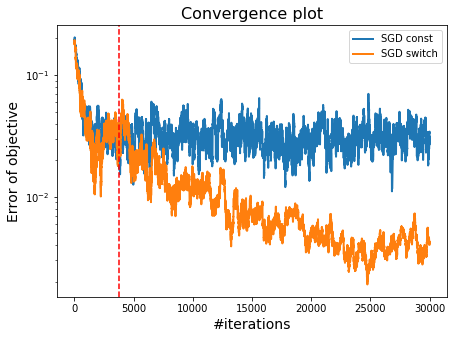

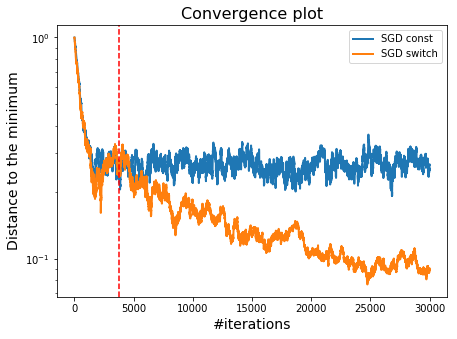

In [25]:
# Plotting to compare with constant stepsize 
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD const", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="SGD switch", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Error of objective", fontsize=14)
plt.legend()
plt.axvline(x=tstar, color = "red", linestyle='dashed')
plt.savefig('images/sgd_switch_err.png', bbox_inches='tight')

# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdcr, label="SGD const", lw=2)
plt.semilogy(err_sgdss , label="SGD switch", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

plt.axvline(x=tstar,  color = "red", linestyle='dashed')
plt.savefig('images/sgd_switch_dist.png', bbox_inches='tight')

## 5. Compare with averaging step

- Implement the average iterate output  
- Compare the solution you obtain for SGD with shrinking stepsizes and SGD with averaging. 
- What happens if you start averaging only the last n iterates? When is averaging useful?


In [26]:
indices = np.random.choice(n, n_iter+1, replace=True)
# steps =   4/(Lmax *np.sqrt(np.arange(1, n_iter + 2))) 
start_late_averaging = 3*n_iter/4
averaging_on = True
# niters =100, averaging_on=False, momentum =0, verbose=True, start_late_averaging = 0
w_sgdar, obj_sgdar, err_sgdar = sgd(w0,model, indices, steps_switch, w_min, n_iter, averaging_on, 0.0, True, start_late_averaging) # (datapasses-5)*n

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 6.92e-01 | 9.99e-01
    1000 | 5.27e-01 | 2.93e-01
    2000 | 5.27e-01 | 2.47e-01
    3000 | 5.29e-01 | 2.66e-01
    4000 | 5.32e-01 | 2.61e-01
    5000 | 5.29e-01 | 2.55e-01
    6000 | 5.19e-01 | 1.99e-01
    7000 | 5.27e-01 | 2.26e-01
    8000 | 5.12e-01 | 1.59e-01
    9000 | 5.13e-01 | 1.82e-01
   10000 | 5.13e-01 | 1.69e-01
   11000 | 5.10e-01 | 1.50e-01
   12000 | 5.09e-01 | 1.23e-01
   13000 | 5.10e-01 | 1.42e-01
   14000 | 5.08e-01 | 1.24e-01
   15000 | 5.07e-01 | 1.15e-01
   16000 | 5.09e-01 | 1.31e-01
   17000 | 5.08e-01 | 1.31e-01
   18000 | 5.07e-01 | 1.28e-01
   19000 | 5.06e-01 | 1.24e-01
   20000 | 5.06e-01 | 1.21e-01
   21000 | 5.08e-01 | 1.29e-01
   22000 | 5.07e-01 | 1.26e-01
   23000 | 5.05e-01 | 9.19e-02
   24000 | 5.03e-01 | 7.73e-02
   25000 | 5.04e-01 | 7.43e-02
   26000 | 5.03e-01 | 6.83e-02
   27000 | 5.03e-01 | 6.51e-02
   28000 | 5.02e-01 | 6.28e-02
   29000 | 5.02e-01 | 6.17e-02


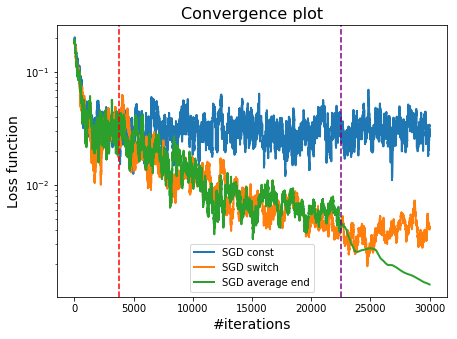

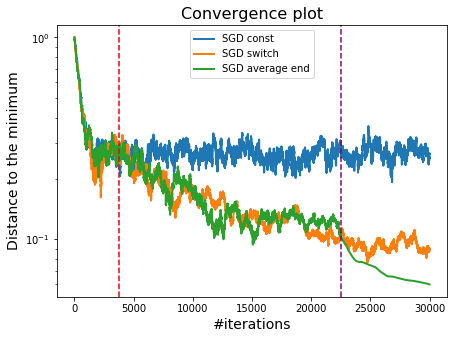

In [27]:
# Plotting to compare constant stepsize, switchting, switching + averaging
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD const", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="SGD switch", lw=2)
plt.semilogy(obj_sgdar - obj_min, label="SGD average end", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Loss function", fontsize=14)
plt.legend()
plt.axvline(x=tstar, color = "red", linestyle='dashed')
plt.axvline(x=start_late_averaging, color = "purple", linestyle='dashed')
plt.savefig('images/sgd_switch_average_err.png', bbox_inches='tight')
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(err_sgdcr, label="SGD const", lw=2)
plt.semilogy(err_sgdss , label="SGD switch", lw=2)
plt.semilogy(err_sgdar , label="SGD average end", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()
plt.axvline(x=tstar, color = "red", linestyle='dashed')
plt.axvline(x=start_late_averaging, color = "purple", linestyle='dashed')
plt.savefig('images/sgd_switch_average_dist.png', bbox_inches='tight')

## Compare with SGD with momentum (SGDm)

- Implement the momentum variant in SGD
- Compare with averaging and decreasing stepsizes with late start
- For what momentum parameters does SGDm work well?
- Combining all the tricks/variants seen so far, what is the best variant of SGD for this problem?

In [28]:
indices = np.random.choice(n, n_iter+1, replace=True)
# steps =   4/(Lmax *np.sqrt(np.arange(1, n_iter + 2))) 
averaging_on = True
start_late_averaging = 0.0
momentum = 1.0
w_sgdm, obj_sgdm, err_sgdm = sgd(w0,model, indices, steps_switch, w_min, n_iter, averaging_on, momentum, True, start_late_averaging) # (datapasses-5)*n

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 6.97e-01 | 9.99e-01
    1000 | 5.50e-01 | 5.15e-01
    2000 | 5.18e-01 | 3.12e-01
    3000 | 5.11e-01 | 2.25e-01
    4000 | 5.06e-01 | 1.69e-01
    5000 | 5.04e-01 | 1.27e-01
    6000 | 5.03e-01 | 1.05e-01
    7000 | 5.03e-01 | 9.30e-02
    8000 | 5.03e-01 | 8.39e-02
    9000 | 5.03e-01 | 7.67e-02
   10000 | 5.02e-01 | 7.15e-02
   11000 | 5.02e-01 | 6.55e-02
   12000 | 5.02e-01 | 6.22e-02
   13000 | 5.02e-01 | 6.01e-02
   14000 | 5.02e-01 | 5.78e-02
   15000 | 5.02e-01 | 5.55e-02
   16000 | 5.02e-01 | 5.40e-02
   17000 | 5.02e-01 | 5.37e-02
   18000 | 5.02e-01 | 5.33e-02
   19000 | 5.02e-01 | 5.23e-02
   20000 | 5.02e-01 | 5.13e-02
   21000 | 5.02e-01 | 5.07e-02
   22000 | 5.02e-01 | 5.02e-02
   23000 | 5.02e-01 | 4.94e-02
   24000 | 5.02e-01 | 4.88e-02
   25000 | 5.02e-01 | 4.85e-02
   26000 | 5.02e-01 | 4.85e-02
   27000 | 5.02e-01 | 4.84e-02
   28000 | 5.01e-01 | 4.78e-02
   29000 | 5.01e-01 | 4.70e-02


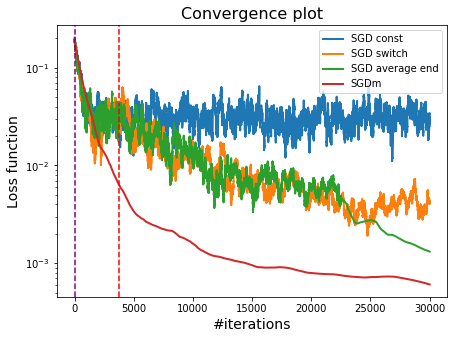

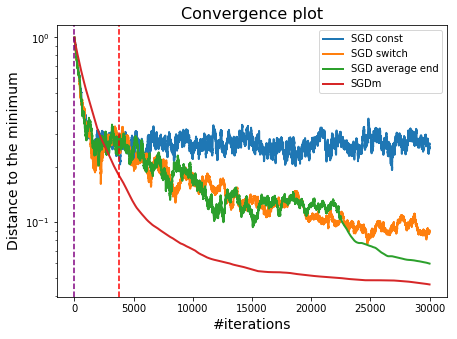

In [29]:
# Plotting to compare constant stepsize, switchting, switching + averaging
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdcr - obj_min, label="SGD const", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="SGD switch", lw=2)
plt.semilogy(obj_sgdar - obj_min, label="SGD average end", lw=2)
plt.semilogy(obj_sgdm - obj_min, label="SGDm", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Loss function", fontsize=14)
plt.legend()
plt.axvline(x=tstar, color = "red", linestyle='dashed')
plt.axvline(x=start_late_averaging, color = "purple", linestyle='dashed')
plt.savefig('images/sgd_switch_average_err.png', bbox_inches='tight')
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(err_sgdcr, label="SGD const", lw=2)
plt.semilogy(err_sgdss , label="SGD switch", lw=2)
plt.semilogy(err_sgdar , label="SGD average end", lw=2)
plt.semilogy(err_sgdm , label="SGDm", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()
plt.axvline(x=tstar, color = "red", linestyle='dashed')
plt.axvline(x=start_late_averaging, color = "purple", linestyle='dashed')
plt.savefig('images/sgd_switch_average_dist.png', bbox_inches='tight')

## Compare with gradient descent

- Complete the code of gradient descent (GD) below
- How much more is the computational cost of a step of gradient descent with respect to the computational cost of a SGD step?  How many steps of gradient descent should you take so that the total computational complexity is equivalent to datapasses * n steps of SGD ? 
- Compare GD with SGD, where on the $x$-axis of the plot you the total computational effort spent
- What happens if you increase the number of datapasses?

In [30]:
def gd(w0, model, step, w_min =[], n_iter=100, verbose=True):
    """Gradient descent algorithm
    """
    w = w0.copy()
    w_new = w0.copy()
    n_samples, n_features = X.shape
    # estimation error history
    errors = []
    err = 1.
    # objective history
    objectives = []
    # Current estimation error
    if np.any(w_min):
        err = norm(w - w_min) / norm(w_min)
        errors.append(err)
    # Current objective
    obj = model.f(w) 
    objectives.append(obj)
    if verbose:
        print("Lauching GD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter ):
        w[:] = w - step * model.grad(w)
        obj = model.f(w) 
        if (sum(w_min)):
            err = norm(w - w_min) / norm(w_min)
            errors.append(err)
        objectives.append(obj)
        if verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return w, np.array(objectives), np.array(errors)

In [31]:
step = 1. / model.lipschitz_constant()
w_gd, obj_gd, err_gd = gd(w0, model, step, w_min, datapasses)
print(obj_gd)

Lauching GD solver...
   it    |   obj    |   err   
       0 | 6.31e-01 | 8.65e-01
       1 | 5.97e-01 | 7.59e-01
       2 | 5.74e-01 | 6.71e-01
       3 | 5.57e-01 | 5.95e-01
       4 | 5.45e-01 | 5.30e-01
       5 | 5.35e-01 | 4.74e-01
       6 | 5.28e-01 | 4.24e-01
       7 | 5.23e-01 | 3.81e-01
       8 | 5.18e-01 | 3.42e-01
       9 | 5.15e-01 | 3.08e-01
      10 | 5.12e-01 | 2.78e-01
      11 | 5.10e-01 | 2.51e-01
      12 | 5.08e-01 | 2.27e-01
      13 | 5.07e-01 | 2.05e-01
      14 | 5.06e-01 | 1.85e-01
      15 | 5.05e-01 | 1.68e-01
      16 | 5.04e-01 | 1.52e-01
      17 | 5.03e-01 | 1.38e-01
      18 | 5.03e-01 | 1.25e-01
      19 | 5.03e-01 | 1.14e-01
      20 | 5.02e-01 | 1.03e-01
      21 | 5.02e-01 | 9.37e-02
      22 | 5.02e-01 | 8.51e-02
      23 | 5.02e-01 | 7.73e-02
      24 | 5.01e-01 | 7.03e-02
      25 | 5.01e-01 | 6.39e-02
      26 | 5.01e-01 | 5.81e-02
      27 | 5.01e-01 | 5.28e-02
      28 | 5.01e-01 | 4.81e-02
      29 | 5.01e-01 | 4.37e-02
[0.69314718 0.631

In [32]:
complexityofGD = n * np.arange(0, datapasses + 1)
print(complexityofGD)

[    0  1000  2000  3000  4000  5000  6000  7000  8000  9000 10000 11000
 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000
 24000 25000 26000 27000 28000 29000 30000]


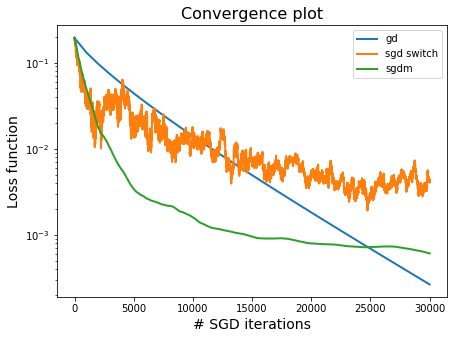

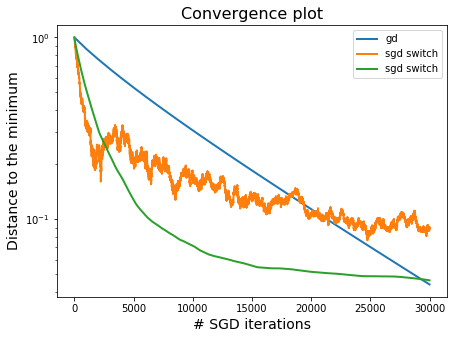

In [33]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(complexityofGD, obj_gd - obj_min, label="gd", lw=2)
plt.semilogy(obj_sgdss - obj_min, label="sgd switch", lw=2)
plt.semilogy(obj_sgdm - obj_min, label="sgdm", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("# SGD iterations", fontsize=14)
plt.ylabel("Loss function", fontsize=14)
plt.legend()
# Distance to the minimum on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(complexityofGD, err_gd, label="gd", lw=2)
plt.semilogy(err_sgdss , label="sgd switch", lw=2)
plt.semilogy(err_sgdm , label="sgd switch", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("# SGD iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

## BONUS: SGD without replacement

-Execute SGD where the indices of the data points are sampled *without* replacement over each datapass

In [34]:
import numpy.matlib
niters = int(datapasses * n) - 1
# With replacement
indices = np.matlib.repmat(np.random.choice(n, n, replace = False), 1, datapasses)
indices = indices.flatten()
###
# steps = 0.1 / np.sqrt(np.arange(1, niters + 2))
w_sgdsw, obj_sgdsw, err_sgdsw = sgd(w0, model, indices, steps_switch, w_min,niters)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 6.95e-01 | 1.00e+00
    1000 | 5.28e-01 | 2.73e-01
    2000 | 5.21e-01 | 1.91e-01
    3000 | 5.21e-01 | 1.89e-01
    4000 | 5.19e-01 | 1.84e-01
    5000 | 5.14e-01 | 1.53e-01
    6000 | 5.11e-01 | 1.31e-01
    7000 | 5.09e-01 | 1.14e-01
    8000 | 5.07e-01 | 1.02e-01
    9000 | 5.06e-01 | 9.11e-02
   10000 | 5.05e-01 | 8.26e-02
   11000 | 5.04e-01 | 7.55e-02
   12000 | 5.04e-01 | 6.96e-02
   13000 | 5.03e-01 | 6.44e-02
   14000 | 5.03e-01 | 6.00e-02
   15000 | 5.03e-01 | 5.61e-02
   16000 | 5.03e-01 | 5.27e-02
   17000 | 5.02e-01 | 4.96e-02
   18000 | 5.02e-01 | 4.69e-02
   19000 | 5.02e-01 | 4.45e-02
   20000 | 5.02e-01 | 4.23e-02
   21000 | 5.02e-01 | 4.03e-02
   22000 | 5.02e-01 | 3.85e-02
   23000 | 5.02e-01 | 3.68e-02
   24000 | 5.02e-01 | 3.53e-02
   25000 | 5.02e-01 | 3.39e-02
   26000 | 5.01e-01 | 3.26e-02
   27000 | 5.01e-01 | 3.14e-02
   28000 | 5.01e-01 | 3.03e-02
   29000 | 5.01e-01 | 2.92e-02


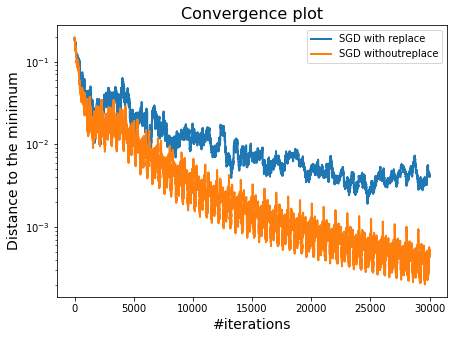

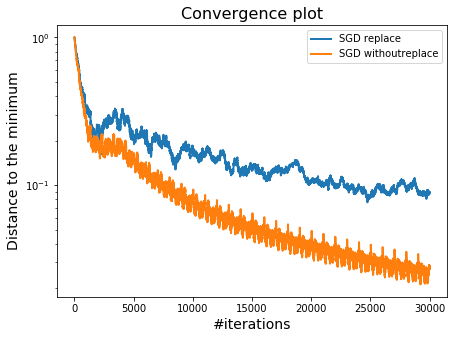

In [35]:
# Error of objective on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(obj_sgdss - obj_min, label="SGD with replace", lw=2)
plt.plot(obj_sgdsw - obj_min, label="SGD withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.plot(err_sgdss , label="SGD replace", lw=2)
plt.plot(err_sgdsw , label="SGD withoutreplace", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to the minimum", fontsize=14)
plt.legend()

## Compare SGD and GD  in terms of test error. That is, use w_model_truth to compare

In [36]:
datapasses = 30;
n_iters = int(datapasses * n)
# With replacement
indices = np.matlib.repmat(np.random.choice(n, n, replace = False), 1, datapasses)
indices = indices.flatten()
## 
steps = 0.25 / np.sqrt(np.arange(1, niters + 2))

## SGD without replacement, decreasing stepsize, averaging at end
indices = np.random.choice(n, n_iter+1, replace=True)
# steps =   4/(Lmax *np.sqrt(np.arange(1, n_iter + 2))) 
w_sgdar, obj_sgdar, err_sgdar    = sgd(w0,model, indices, steps_switch, w_model_truth, n_iter, True, False, 3*n_iter/4) # (datapasses-5)*n
# w_sgdsaw, obj_sgdsaw, err_sgdsaw = sgd(w0,model, indices, steps, w_model_truth, niters, True, False, (datapasses-5)*n);

## SGD without replacement, decreasing stepsize, no averaging
w_sgdsw, obj_sgdsw, err_sgdsw = sgd(w0,model, indices, steps, w_model_truth, n_iter, verbose = False);
## GD
step = 1. / model.lipschitz_constant()
w_gd, obj_gd, err_gd = gd(w0, model, step, w_model_truth, datapasses, verbose = False)
complexityofGD = n * np.arange(0, datapasses + 1)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 6.93e-01 | 9.99e-01
    1000 | 5.49e-01 | 6.36e-01
    2000 | 5.21e-01 | 4.89e-01
    3000 | 5.13e-01 | 4.18e-01
    4000 | 5.08e-01 | 3.79e-01
    5000 | 5.06e-01 | 3.51e-01
    6000 | 5.04e-01 | 3.32e-01
    7000 | 5.04e-01 | 3.20e-01
    8000 | 5.03e-01 | 3.10e-01
    9000 | 5.03e-01 | 3.05e-01
   10000 | 5.03e-01 | 3.00e-01
   11000 | 5.02e-01 | 2.96e-01
   12000 | 5.02e-01 | 2.93e-01
   13000 | 5.02e-01 | 2.91e-01
   14000 | 5.02e-01 | 2.88e-01
   15000 | 5.02e-01 | 2.85e-01
   16000 | 5.02e-01 | 2.83e-01
   17000 | 5.02e-01 | 2.81e-01
   18000 | 5.02e-01 | 2.79e-01
   19000 | 5.02e-01 | 2.78e-01
   20000 | 5.01e-01 | 2.77e-01
   21000 | 5.01e-01 | 2.76e-01
   22000 | 5.01e-01 | 2.76e-01
   23000 | 5.02e-01 | 2.75e-01
   24000 | 5.01e-01 | 2.75e-01
   25000 | 5.01e-01 | 2.75e-01
   26000 | 5.01e-01 | 2.75e-01
   27000 | 5.01e-01 | 2.75e-01
   28000 | 5.01e-01 | 2.75e-01
   29000 | 5.01e-01 | 2.75e-01


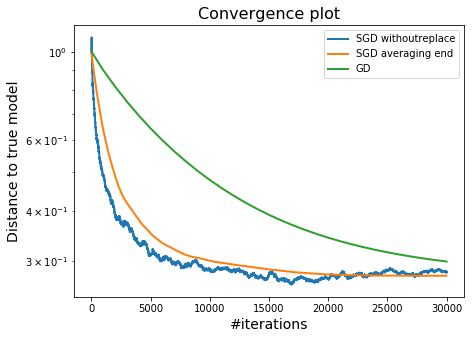

In [37]:
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.yscale("log")
plt.semilogy(err_sgdsw , label="SGD withoutreplace", lw=2)
plt.semilogy(err_sgdar , label="SGD averaging end", lw=2)
plt.semilogy(complexityofGD, err_gd , label="GD", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Distance to true model", fontsize=14)
plt.legend()

## THE END!

In [38]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split

def get_data(dataname):
    data = load_svmlight_file(dataname)
    return data[0], data[1]
#dataname = "duke"
dataname = "colon-cancer"
X, y = get_data(dataname)
X = np.squeeze(np.asarray(X.todense()))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [39]:
# split test and training 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [40]:
def fit_apply_normalization(X):
    Xstd = np.std(X,0);
    mask = Xstd !=0
    Xmean = np.mean(X,0);
    X = (X[:,mask] - Xmean[mask])/Xstd[mask];
    return Xmean, Xstd, mask, X

def apply_normalization(X, Xmean, Xstd, mask):
    X = (X[:,mask] - Xmean)/Xstd;
    return  X

# Xmean, Xstd, mask, X = fit_apply_normalization(X_train)
[n, d] = X_train.shape

In [41]:
# r = int(2*np.round(n));
# P = randn(d,r);
# X_train = X_train.dot(P);
# d = r;
X_train = X_train.dot(X_train.transpose());
d = n

In [42]:
## masking y to -1 and 1
indneg = y_train == min(y_train)
y_train[indneg] = -1;
y_train[~indneg] = 1;

In [43]:
lbda = 1. / n ** (0.5)
#model = LinReg(X, y, lbda)
model = LogReg(X_train, y_train, lbda)

In [44]:
from scipy.optimize import fmin_l_bfgs_b

w_init = np.zeros(d).T
w_min, obj_min, _ = fmin_l_bfgs_b(model.f, w_init, model.grad, args=(), pgtol=1e-30, factr =1e-30)

print(obj_min)
print(norm(model.grad(w_min)))

0.6931471805599453
538.2863086680197


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in exp
  if sys.path[0] == '':


In [45]:
w_min 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [46]:
datapasses = 15;
w0 = np.zeros(d)
niters = int(datapasses * n)
# # With replacement
indices = np.matlib.repmat(np.random.choice(n, n, replace = False), 1, datapasses)
indices = indices.flatten()
## SGD without replacement and decreasing stepsize
max_squared_sum = np.mean(np.sum(X ** 2, axis=1)) # a trick for an initial estimate of stepsize
steps = (0.01/ (max_squared_sum + lbda)) / np.sqrt(np.arange(1, niters + 2))
w_sgdsw, obj_sgdsw, err_sgdsw = sgd(w0,model, indices, steps, w_min, niters, True, True, (datapasses-5)*n);
# # GD
step = 2. / model.lipschitz_constant()
w_gd, obj_gd, err_gd = gd(w0, model, step, w_min, datapasses, verbose = True)
complexityofGD = n * np.arange(0, datapasses + 1)

Lauching SGD solver...
   it    |   obj    |   err   
       0 | 4.60e+00
      62 | 7.93e-01
     124 | 5.75e-01
     186 | 4.42e-01
     248 | 3.68e-01
     310 | 3.26e-01
     372 | 2.96e-01
     434 | 2.75e-01
     496 | 2.57e-01
     558 | 2.43e-01
Lauching GD solver...
   it    |   obj    |   err   
       0 | 4.74e-01 | 1.00e+00
       1 | 4.01e-01 | 1.00e+00
       2 | 3.75e-01 | 1.00e+00
       3 | 3.58e-01 | 1.00e+00
       4 | 3.46e-01 | 1.00e+00
       5 | 3.36e-01 | 1.00e+00
       6 | 3.28e-01 | 1.00e+00
       7 | 3.21e-01 | 1.00e+00
       8 | 3.14e-01 | 1.00e+00
       9 | 3.08e-01 | 1.00e+00
      10 | 3.03e-01 | 1.00e+00
      11 | 2.97e-01 | 1.00e+00
      12 | 2.93e-01 | 1.00e+00
      13 | 2.88e-01 | 1.00e+00
      14 | 2.84e-01 | 1.00e+00


In [47]:
obj_min = min(obj_gd[-1],   obj_sgdsw[-1], obj_min)

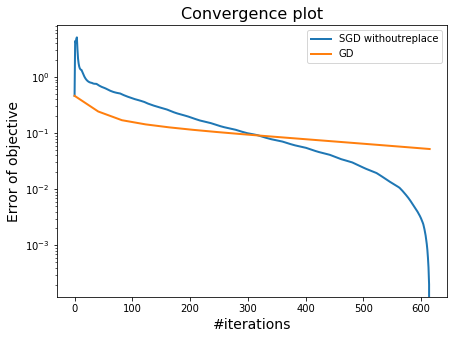

In [48]:
# Distance to the minimizer on a logarithmic scale
plt.figure(figsize=(7, 5))
plt.semilogy(obj_sgdsw - obj_min, label="SGD withoutreplace", lw=2)
plt.semilogy(complexityofGD, obj_gd - obj_min, label="GD", lw=2)
plt.title("Convergence plot", fontsize=16)
plt.xlabel("#iterations", fontsize=14)
plt.ylabel("Error of objective", fontsize=14)
plt.legend()

In [49]:
## Test error 
# X_test, y_test = get_data("duke.val")
# X_test = np.squeeze(np.asarray(X_test.todense()))
# [nt, dt] = X_test.shape

In [50]:
X_test.shape

(21, 2000)

In [51]:
X_test = X_test.dot(P);

NameError: name 'P' is not defined

In [ ]:
## masking y to -1 and 1
indneg = y_test == min(y_test)
y_test[indneg] = -1;
y_test[~indneg] = 1;

In [ ]:
# applying the same normalization
# Xt = apply_normalization(Xt, Xmean, Xstd, mask)

In [ ]:
def Lin_class_test(w): 
      return np.mean(X_test.dot(w)*y_test >=0)

In [ ]:
print("SGD test accuracy: ", Lin_class_test(w_sgdsw))
print("GD test accuracy: ", Lin_class_test(w_gd))

In [ ]:
# To improve the test error, scale and normalize X (and Xt accordingly), and add an affine term to the linear classifier

In [ ]:
yt= Lin_class_test(w_sgdsw)

In [ ]:
w_sgdsw